# DEDS Week 9

## Imports

In [67]:
import pyodbc
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## Database connecties

In [68]:
DB_GO = {
    "servername" : r"VISSIE\SQLEXPRESS",
    "database" : "GREAT_OUTDOORS"}

export_conn_go = pyodbc.connect(f"""DRIVER={'SQL SERVER'};
                             SERVER={DB_GO['servername']};
                             DATABASE={DB_GO['database']};
                             Trusted_Connection=yes
                             """)

export_cursor_go = export_conn_go.cursor()

## Dataframes maken

In [69]:
def create_dataframes_sql(connection):
    dictionary : dict = {}
    query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE';"
    key = "TABLE_NAME"
    
    tables = pd.read_sql(query, connection)
    
    for table in tables[key].tolist():
        dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)
    
    return dictionary

sdm_frames = create_dataframes_sql(export_conn_go)

orders = sdm_frames["order_details"]
inventory = sdm_frames["inventory"]

orders_specfic = orders[["REVENUE", "QUANTITY", "UNIT_COST", "UNIT_PRICE"]]
orders_specfic

C:\Users\jdvis_x5odeao\AppData\Local\Temp\ipykernel_13892\727123705.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables = pd.read_sql(query, connection)
C:\Users\jdvis_x5odeao\AppData\Local\Temp\ipykernel_13892\727123705.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)


,REVENUE,QUANTITY,UNIT_COST,UNIT_PRICE
0,2.0,84,4.0,6.0
1,2.0,126,4.0,6.0
2,2.0,122,4.0,6.0
3,2.0,122,4.0,6.0
4,1.0,272,4.0,6.0
...,...,...,...,...
37752,3.0,70,6.0,9.0
37753,3.0,44,6.0,12.0
37754,60.0,8,80.0,200.0
37755,5.0,24,5.0,10.0


In [70]:
X = orders_specfic.loc[orders_specfic['REVENUE'].notna(), :]
X = X.drop('REVENUE', axis = 1)
y = orders_specfic.loc[orders_specfic['REVENUE'].notna(), ['REVENUE']]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37757 entries, 0 to 37756
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   QUANTITY    37757 non-null  int64  
 1   UNIT_COST   37757 non-null  float64
 2   UNIT_PRICE  37757 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.2 MB


In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.15,
    random_state = 42
)

In [72]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(X_train, y_train)
reg_model

LinearRegression()

In [73]:
y_pred= reg_model.predict(X_test)
y_pred

array([[ 79.66763982],
       [ 29.04110232],
       [ 19.38378219],
       ...,
       [107.76722057],
       [  5.50080035],
       [  3.92433131]], shape=(5664, 1))

In [74]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns = {0 : 'prediction_revenue'})
prediction_df

,prediction_revenue
0,79.667640
1,29.041102
2,19.383782
3,2.661289
4,8.125555
...,...
5659,13.015010
5660,7.179215
5661,107.767221
5662,5.500800


In [75]:
# Reset index for y_test and rename the column for clarity
y_test_reset = y_test.reset_index(drop=True)
y_test_reset.columns = ['actual_revenue']

# Combine actual and predicted values
y_test_prediction_merge = pd.concat([y_test_reset, prediction_df], axis=1)

# Show only rows where prediction is not null (which should be all)
y_test_prediction_merge.loc[y_test_prediction_merge['prediction_revenue'].notna(), :]


,actual_revenue,prediction_revenue
0,101.0,79.667640
1,32.0,29.041102
2,16.0,19.383782
3,1.0,2.661289
4,12.0,8.125555
...,...,...
5659,14.0,13.015010
5660,6.0,7.179215
5661,124.0,107.767221
5662,3.0,5.500800


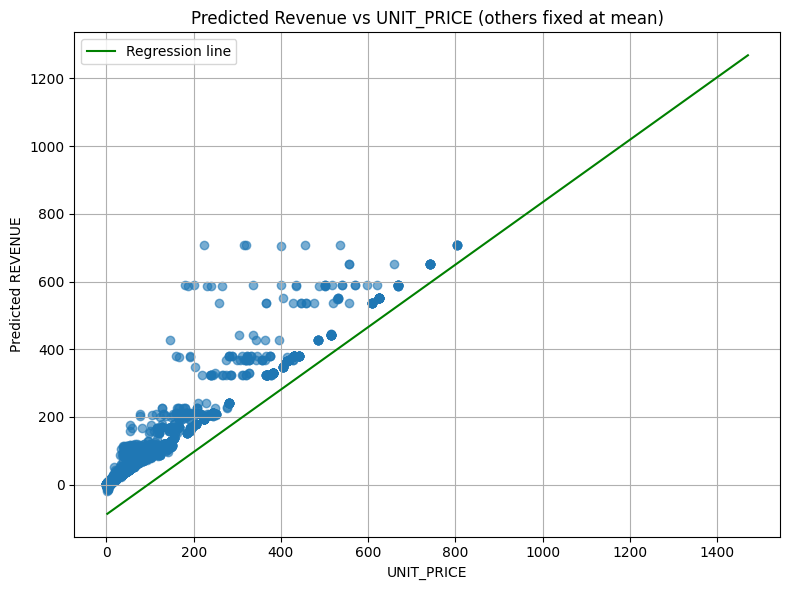

In [76]:
intercept = reg_model.intercept_[0]
coefs = reg_model.coef_[0]

coef_map = dict(zip(X.columns, coefs))

quantity_mean = X['QUANTITY'].mean()
unit_cost_mean = X['UNIT_COST'].mean()

unit_price_range = np.linspace(X['UNIT_PRICE'].min(), X['UNIT_PRICE'].max(), 100)

predicted_revenue = (
    coef_map['QUANTITY'] * quantity_mean +
    coef_map['UNIT_COST'] * unit_cost_mean +
    coef_map['UNIT_PRICE'] * unit_price_range +
    intercept
)

plt.figure(figsize=(8, 6))
plt.scatter(
    y_test_prediction_merge['actual_revenue'], 
    y_test_prediction_merge['prediction_revenue'], 
    alpha=0.6
)
plt.plot(unit_price_range, predicted_revenue, label='Regression line', color='green')
plt.xlabel('UNIT_PRICE')
plt.ylabel('Predicted REVENUE')
plt.title('Predicted Revenue vs UNIT_PRICE (others fixed at mean)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [77]:
mean_squared_error(y_test_prediction_merge['actual_revenue'], y_test_prediction_merge['prediction_revenue'])

710.1639808428224

In [78]:
mean_absolute_error(y_test_prediction_merge['actual_revenue'], y_test_prediction_merge['prediction_revenue'])

9.909290632568906